In [1]:
%matplotlib inline

In [38]:
import Signal
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.signal as sig
import sys
from scipy.signal import freqz
from scipy.signal import butter, lfilter
import scipy.signal as signal
from scipy import fftpack

## Generate Signal

In [65]:
def graph_signals(time_axis, array, signalNum=0, timestart = 0.06, dur=0.0001, sr=1000000):
    time_axis = np.array(time_axis)*1000
    timeIdx = int(timestart*sr)
    print(timeIdx)
    durIdx = int(dur*sr)
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[0][timeIdx:timeIdx+durIdx],'b-',color="green")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[1][timeIdx:timeIdx+durIdx],'b-',color="red")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[2][timeIdx:timeIdx+durIdx],'b-',color="blue")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[3][timeIdx:timeIdx+durIdx],'b-',color="purple")
    plt.xlabel('Time (ms)')
    plt.ylabel('Charge (arbitrary)')
    plt.show()
    signals = []
    for signal in array:
        signals.append((time_axis[timeIdx:timeIdx + durIdx], signal[timeIdx:timeIdx+durIdx]))
    return signals

In [166]:
random.seed(1)
source = [0,0.01] #m
coords = [[-0.01, 0], [0, 0], [.01, 0], [.02, 0]]
freq = 20000 #Hz
sos = 1531 #m/s (MAY NEED TO BE CALIBRATED)
sr = 300000 #Hz
read = 1.8 #s
noise = 0.5 #standard deviation
time_on = .01 #s --ping duration
ping_period = 2 #s
ping_start = 1
#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(source, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read, 1/sr)

1.0000092371885196
1.0000065316786415
1.0000092371885196
1.0000146052774495


300000


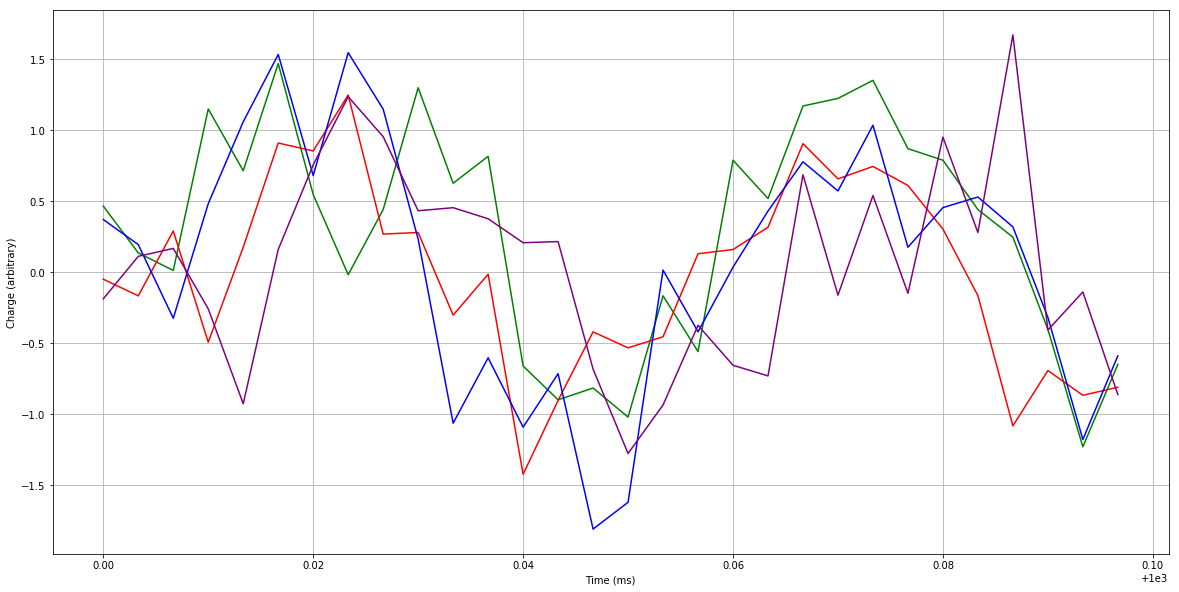

In [167]:
short_signals = graph_signals(times, signals, timestart=1.00,sr=sr)

## Signal Processing

In [168]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [169]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [170]:
def bandpassFilter1(signals):
    filtered_signals = []
    for signal in signals:
        diff = freq*.1
        lowcut = (freq-diff)*1000
        highcut = (freq+diff)*1000
        t = signal[0]
        y = butter_bandpass_filter(signal, lowcut, highcut, sr*1000, order=4)
        filtered_signals.append((y))
    return filtered_signals

In [171]:
def bandpassFilter(signals):
    filtered_signals = []
    for signal in signals:
        diff = freq*.1
        lowcut = (freq-diff)*1000
        highcut = (freq+diff)*1000
        t = signal[0]
        y = butter_bandpass_filter(signal[1], lowcut, highcut, sr*1000, order=4)
        filtered_signals.append((t,y))
    return filtered_signals

In [172]:
filtered_signals = bandpassFilter(short_signals)

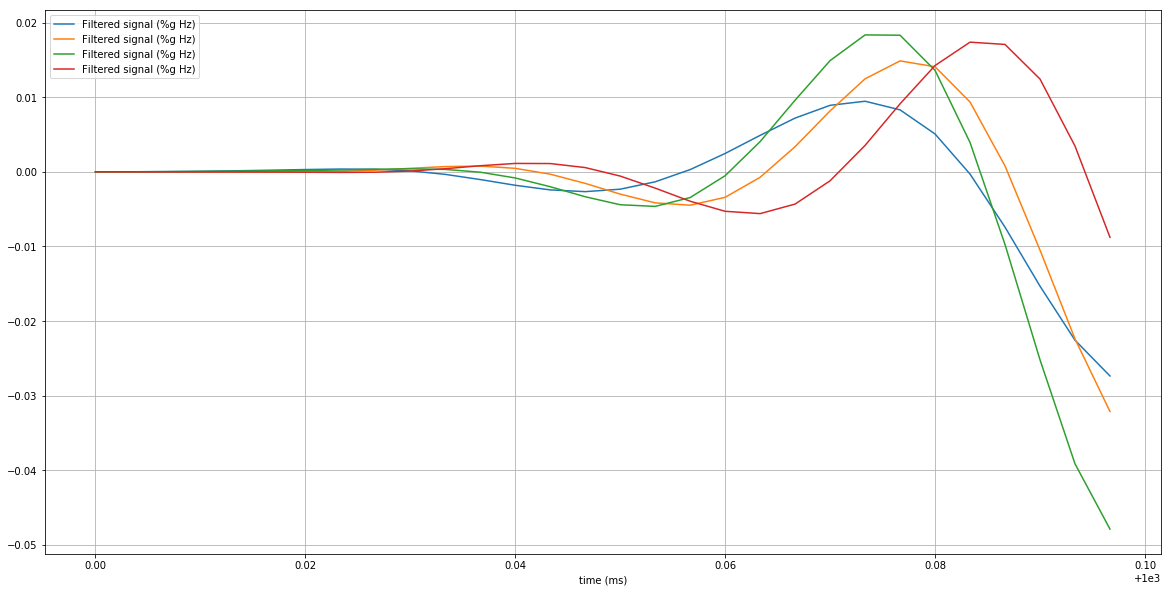

In [173]:
plt.figure(figsize = (20,10))
plt.plot(filtered_signals[0][0], filtered_signals[0][1], label='Filtered signal (%g Hz)')
plt.plot(filtered_signals[1][0], filtered_signals[1][1], label='Filtered signal (%g Hz)')
plt.plot(filtered_signals[2][0], filtered_signals[2][1], label='Filtered signal (%g Hz)')
plt.plot(filtered_signals[3][0], filtered_signals[3][1], label='Filtered signal (%g Hz)')
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## STFT

In [188]:
#TODO:Debug Code, add filtered signals in, remove x-axis dependency
random.seed(1)
source = [0,0.01] #m
coords = [[0, 0], [0.01, 0], [.02, 0], [.03, 0]]
freq = 40000 #Hz
sos = 1531 #m/s (MAY NEED TO BE CALIBRATED)
sr = 300000 #Hz
read = 1.8 #s
noise = 0.2 #standard deviation
time_on = .01 #s --ping duration
ping_period = 2 #s
ping_start = 1
#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(source, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read, 1/sr)

times = []
plot=False
for arrNum in range(4):
    time_threshold = .5
    freq_threshold = 25
    num_threshold = 0
    window = 30
    filtered_signals = bandpassFilter1(signals)
    idx = np.where(np.array(filtered_signals[arrNum])>time_threshold)
    for i in idx[0]:
        lbound = i-window
        ubound = i+window
        if lbound < 0:
            lbound = 0
        if ubound >= len(filtered_signals[arrNum]):
            ubound = len(filtered_signals[arrNum])-1
        X = fftpack.fft(filtered_signals[arrNum][lbound:ubound])
        freqs = fftpack.fftfreq(len(filtered_signals[arrNum][lbound:ubound])) * sr
        freqIdx = np.where(freqs == freq)
        threshold = np.abs(X[freqIdx[0][0]])
        if threshold > freq_threshold:
            time = i
            if plot:
                plt.figure(figsize=(20,10))
                plt.plot(filtered_signals[arrNum][lbound:ubound])
                plt.show()
            times.append(time)
            break
    print(time/sr)

1.0000065316786415
1.0000092371885196
1.0000146052774495
1.0000206549814512
1.0001866666666666
1.0001866666666666
1.0002
1.0002233333333332


In [189]:
phases = []
phase_data = []
maxTime = max(times)
print("TIME: " +str(maxTime/sr))
f_window=15
lbound = maxTime
ubound = maxTime+f_window*2
if lbound < 0:
    lbound = 0
if ubound >= len(filtered_signals[arrNum]):
    ubound = len(filtered_signals[arrNum])-1
for arrNum in range(4):
    phase_info = filtered_signals[arrNum][lbound:ubound]
    phase_data.append(phase_info)
    X = fftpack.fft(filtered_signals[arrNum][lbound:ubound])
    freqs = fftpack.fftfreq(len(filtered_signals[arrNum][lbound:ubound])) * sr
    freqIdx = np.where(freqs == freq)
    complexMag = X[freqIdx[0][0]]
    print(complexMag)
    phase = np.angle(complexMag,deg=True)
    phases.append(phase)
    print(phase)
print("------------------------------------------")
print(phases)
phaseDiff = []
for i in range(3):
    phaseDiff.append(np.abs(phases[i+1]-phases[i]))
phaseDiff = np.array(phaseDiff)
print(phaseDiff/360*sos/freq)

TIME: 1.0002233333333332
(-13.761966042276425+8.512047962696212j)
148.26238998678204
(-5.257775015472973+15.024058156240683j)
109.28785370255406
(12.786901974761458+8.730214359016408j)
34.32317612265596
(8.382249544650072-12.907729629536108j)
-57.000399912529254
------------------------------------------
[148.26238998678204, 109.28785370255406, 34.32317612265596, -57.000399912529254]
[0.00414375 0.0079702  0.00970947]


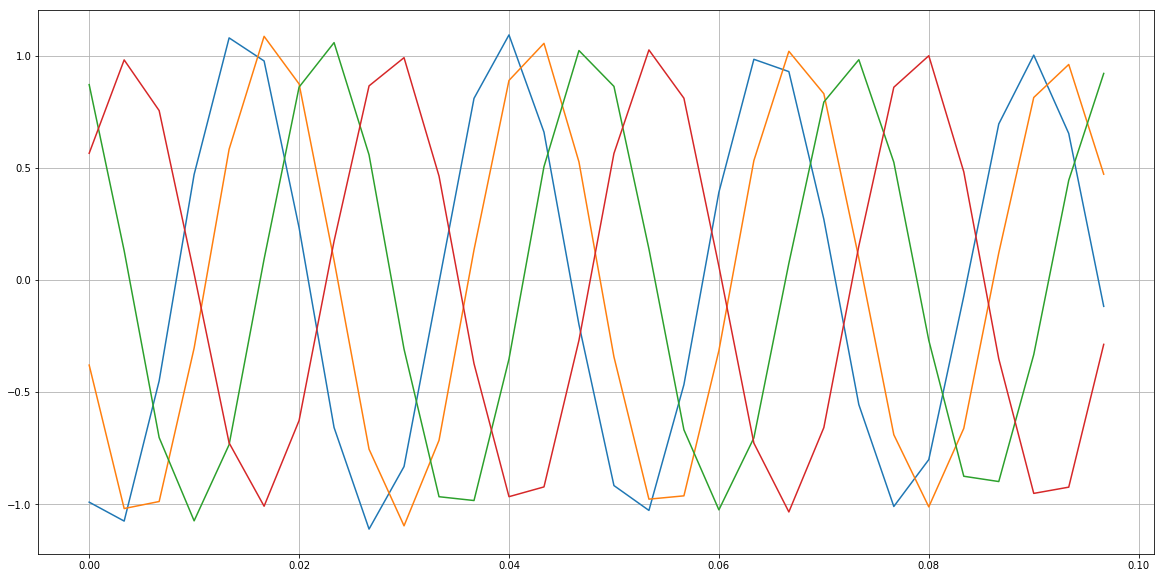

In [190]:
plt.figure(figsize=(20,10))
plt.grid(True)
t = np.arange(0, len(phase_data[0]))/sr*1000
for phase_info in phase_data:
    plt.plot(t,phase_info)
plt.show()

## MUSIC ALGORITHM